In [1]:
import pandas as pd

# SMOTE Models

In [2]:
# final_dataset is unbalanced
data = pd.read_csv("data/final_dataset.csv", index_col=0)
del data['Unnamed: 0.1']

In [3]:
data.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,language,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,year,artist_past_performance
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,en,0,0.388542,0.214583,0,6.225200,111,17.830752,2017,0
1,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,en,1,0.460365,0.150858,0,4.374450,420,96.012070,2005,7
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside,CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,en,0,0.611454,0.113423,0,4.051117,341,84.174322,2012,0
3,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,en,0,0.570486,-0.442188,2,3.219333,347,107.786291,2019,0
4,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,"Hold your breath, don't look down, keep trying...",70,3GNzXsFbzdwM0WKCZtgeNP,Chapters,2019-04-26,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,...,en,1,0.609292,0.232474,0,3.745333,359,95.852617,2019,0


In [4]:
# check for nan values in df
data.isna().values.any()

False

In [5]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'key', 'loudness',
           'mode', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['track_artist', 'playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'key', 'loudness',
           'mode', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
               'track_artist', 'playlist_genre', 'playlist_subgenre']

In [6]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rc("font", size=14)

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [8]:
# Some of the variables are strings and need to be converted to categoricals (ints) to be machine interpretable
le = LabelEncoder()
data[categorical_columns] = data[categorical_columns].apply(le.fit_transform)

In [9]:
data.isna().values.any()

False

In [10]:
# min-max scaling of numerical features
data[numerical_columns]=(data[numerical_columns]-data[numerical_columns].min())/(data[numerical_columns].max()-data[numerical_columns].min())

In [11]:
data.isna().values.any()

False

In [12]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [13]:
len(X), len(y)

(15405, 15405)

In [14]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from imblearn.over_sampling import SMOTE

In [16]:
# def resample_data(X_train, y_train, target): 
#     resampling = X_train.copy()
#     resampling[target] = y_train.values
#     majclass = resampling[resampling[target]==0]
#     minclass = resampling[resampling[target]==1]
#     return majclass, minclass

In [17]:
def upsample(X_train, y_train, ratio=1.0):
    # Upsampling using SMOTE
    sm = SMOTE(random_state=42, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [20]:
# resample_data(X_train, y_train, 'Hit Or Not')

In [22]:
X_train_up, y_train_up = upsample(X_train,y_train, ratio = 0.75)

14325 14325


## Feature Selection 

In [23]:
from sklearn.feature_selection import mutual_info_classif

In [24]:
mutual_info_classif(X_train_up, y_train_up ,discrete_features='auto', n_neighbors=5, copy=True, random_state=None)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0.12764596, 0.12395621, 0.21377104, 0.01435135, 0.0979983 ,
       0.10535558, 0.05513778, 0.03294038, 0.12593669, 0.11368722,
       0.0687057 , 0.05621832, 0.04756767, 0.15676703, 0.03108602,
       0.1065448 , 0.01545162, 0.14676644, 0.01376721, 0.03254072])

In [27]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train_up, np.asarray(y_train_up).ravel())
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False False False  True False  True False  True False  True False  True
  True  True  True  True  True False False False]
[ 4  2  6  1  7  1  9  1  3  1  5  1  1  1  1  1  1 11  8 10]


In [30]:
# select the features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train_up[X_train_up.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [33]:
# inspecting the features selected
X_train_log.head()

,loudness,speechiness,instrumentalness,valence,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx
0,0.595281,0.016414,0.001345,0.131172,0.610737,0.427226,0.000000,0.421411,0.050557,0.044163
1,0.854379,0.030706,0.029363,0.268408,0.800000,0.573460,0.015267,0.269900,0.018252,0.023329
2,0.772034,0.052814,0.000006,0.116035,0.294029,0.489153,0.091603,0.505272,0.155320,0.115552
3,0.826453,0.089996,0.000005,0.631681,0.510362,0.563565,0.000000,0.467352,0.083957,0.066943
4,0.881996,0.063756,0.000000,0.396563,0.505696,0.676435,0.122137,0.393570,0.146925,0.135947


In [35]:
logreg = LogisticRegression()
logreg.fit(X_train_log, np.asarray(y_train_up).ravel())

LogisticRegression()

In [37]:
y_pred = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2788  752]
 [ 683  399]]


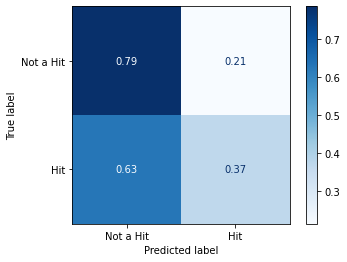

In [40]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(logreg, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


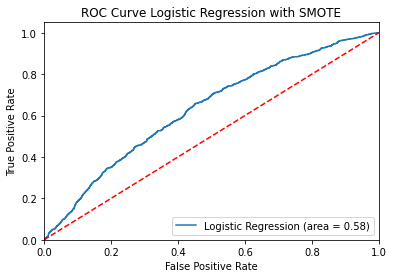

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_log)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression with SMOTE')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [50]:
best_clf = clf.fit(X_train_up, y_train_up)
best_clf.best_estimator_

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/loc

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

LogisticRegression(C=100)

In [51]:
logreg2 = LogisticRegression(C=100)
logreg2.fit(X_train_log, np.asarray(y_train_up).ravel())

LogisticRegression(C=100)

In [55]:
y_pred = logreg2.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.69


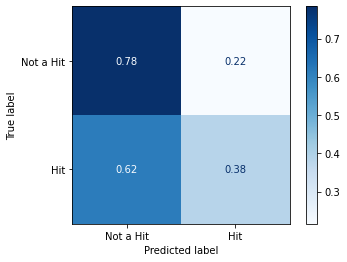

In [56]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(logreg2, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


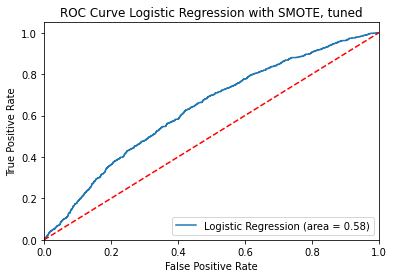

In [57]:
logit_roc_auc = roc_auc_score(y_test, logreg2.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test, logreg2.predict_proba(X_test_log)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression with SMOTE, tuned')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Bagging Classifier

In [58]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, random_state=0).fit(X_train_up, y_train_up)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7659022068368672

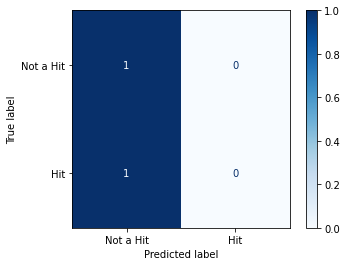

In [62]:
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


In [58]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, random_state=0).fit(X_train_up, y_train_up)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7659022068368672

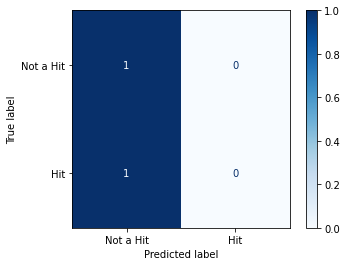

In [62]:
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


In [76]:
# model = BaggingClassifier()
# # evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

## Fully Connected NN

In [77]:
import tensorflow as tf
from tensorflow import keras
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network

In [80]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(20,)),

    keras.layers.Dense(11, activation=tf.nn.relu, kernel_initializer='normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
# RMS prop, sigmoid for final

In [84]:
# run with diff LR
opt = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_up, y_train_up, epochs=50, batch_size=100, validation_split = 0.3)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/50
115/115 [==============================] - 0s 2ms/step - loss: 0.8817 - accuracy: 0.6613 - val_loss: 1.4436 - val_accuracy: 0.0000e+00
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.6910 - val_loss: 1.6584 - val_accuracy: 0.0000e+00
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 0.6111 - accuracy: 0.7011 - val_loss: 2.1973 - val_accuracy: 0.0000e+00
Epoch 4/50
115/115 [==============================] - 0s 2ms/step - loss: 0.6137 - accuracy: 0.6937 - val_loss: 2.8965 - val_accuracy: 0.0000e+00
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.6872 - val_loss: 0.8746 - val_accuracy: 0.1784
Epoch 6/50
115/115 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.6703 - val_loss: 1.1566 - val_accuracy: 0.0017
Epoch 7/50
115/115 [==============================] - 0s 1ms/step - loss: 0.6101 - accuracy: 0.6965 - val_loss: 1.2671 - val_accurac

In [85]:
test_acc

0.765469491481781

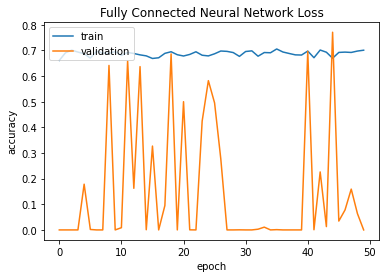

In [87]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### MLP Classifier

In [88]:
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(15, ), activation='relu', solver='adam', 
                                             alpha=0.001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                             max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.2, 
                                             nesterovs_momentum=True, early_stopping=False, validation_fraction=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                             n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train_up, y_train_up)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(15,), max_iter=1000,
              momentum=0.2, validation_fraction=0.2)

In [89]:
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)

In [90]:
accuracy

0.7393118798108134

In [92]:
mlp_gs = sklearn.neural_network.MLPClassifier(max_iter=1000, batch_size='auto', verbose=False,
                                             warm_start=False, nesterovs_momentum=True, early_stopping=False,
                                             validation_fraction=0.2)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.005, 0.05],
    'learning_rate': ['constant','adaptive']}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_up, y_train_up) # X is train samples and y is the corresponding labels

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5,
             estimator=MLPClassifier(max_iter=1000, validation_fraction=0.2),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.005, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [93]:
print('Best parameters:\n', clf.best_params_)

Best parameters:
 {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [94]:
clf.predict(X_test)
clf.score(X_test, np.asarray(y_test).ravel())

0.7436174816096928

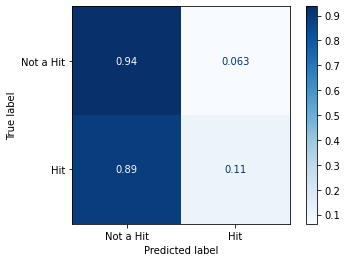

In [95]:
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


## Gradient Boosting Classifier

In [96]:
clf = GradientBoostingClassifier(random_state=2, n_estimators = 700, max_features = 15, learning_rate = 0.005)
clf.fit(X_train_up, np.asarray(y_train_up).ravel())
clf.predict(X_test)
clf.score(X_test, np.asarray(y_test).ravel())

0.7540025962786673

In [97]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,cv=5)
gsearch1.fit(X_train_up,np.asarray(y_train_up).ravel())

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [98]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.843906490921729)

In [99]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train_up,np.asarray(y_train_up).ravel())

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='roc_auc')

In [100]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 200}, 0.8643063313323097)

In [105]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=15,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(X_train_up,np.asarray(y_train_up).ravel())
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 40, 'min_samples_split': 1000}, 0.8300660937020462)

In [107]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=15, min_samples_split=1000, min_samples_leaf=40, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train_up,np.asarray(y_train_up).ravel())
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 17}, 0.8513381167549413)

In [108]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=15,min_samples_split=1000, min_samples_leaf=40, subsample=0.8, random_state=10,max_features=17),
param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train_up,np.asarray(y_train_up).ravel())
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.85}, 0.8528224051317966)

In [109]:
boosting_tuned = GradientBoostingClassifier(learning_rate=0.01, n_estimators=60,max_depth=15, min_samples_split=1000,min_samples_leaf=40, subsample=0.8, random_state=10, max_features=17)
boosting_tuned.fit(X_train_up,np.asarray(y_train_up).ravel())

GradientBoostingClassifier(learning_rate=0.01, max_depth=15, max_features=17,
                           min_samples_leaf=40, min_samples_split=1000,
                           n_estimators=60, random_state=10, subsample=0.8)

In [110]:
boosting_tuned.predict(X_test)
boosting_tuned.score(X_test, np.asarray(y_test).ravel())

0.7659022068368672

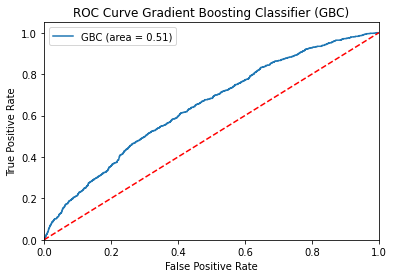

In [111]:
gbc_roc_auc = roc_auc_score(y_test, boosting_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, boosting_tuned.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBC (area = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Gradient Boosting Classifier (GBC)')
plt.legend(loc="upper left")
plt.show()

In [112]:
boosting_tuned.feature_importances_

array([0.0035707 , 0.00127434, 0.01719822, 0.00083132, 0.26724781,
       0.06180328, 0.03072506, 0.03509599, 0.00050522, 0.01144345,
       0.00186019, 0.00187121, 0.00953818, 0.40208622, 0.08026292,
       0.00735848, 0.00552767, 0.00141011, 0.01245152, 0.04793811])

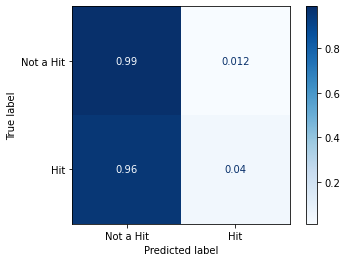

In [113]:
disp = plot_confusion_matrix(boosting_tuned, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


# Using Balanced non SMOTE data

In [126]:
data = pd.read_csv("data/final_subset.csv", index_col = 0)

In [127]:
data.head()

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance
1,0,3,14,0.845,0.652,-7.504,0.216,0.00432,0.007230,0.4890,...,111.904,262467,1,0.460365,0.150858,0,4.374450,420,96.012070,7
4,70,3,23,0.496,0.639,-6.157,0.055,0.28000,0.000000,0.0975,...,147.764,224720,1,0.609292,0.232474,0,3.745333,359,95.852617,0
5,52,3,14,0.764,0.594,-10.050,0.185,0.59100,0.000000,0.1450,...,87.261,286441,1,0.590514,0.200076,0,4.774017,634,132.802218,2
9,72,4,6,0.865,0.657,-6.722,0.076,0.04040,0.000000,0.1400,...,111.115,268960,1,0.409803,0.013691,3,4.482667,722,161.064842,8
11,8,3,9,0.662,0.748,-3.041,0.268,0.68800,0.000008,0.0841,...,82.331,239027,1,0.737900,0.459439,7,3.983783,554,139.063788,0


In [134]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
             'playlist_genre', 'playlist_subgenre', 'artist_past_performance']

In [135]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [137]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression

In [138]:
logreg = LogisticRegression()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train, np.asarray(y_train).ravel())
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[ True False False  True  True  True  True  True False  True  True False
  True False False False False  True]
[1 2 3 1 1 1 1 1 7 1 1 4 1 9 8 6 5 1]


In [140]:
# select the features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train[X_train.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [141]:
# inspecting the features selected
X_train_log.head()

,danceability,speechiness,acousticness,instrumentalness,liveness,valence,lyrical_subjectivity,lyrical_polarity,minutes,artist_past_performance
1881,0.830,0.4320,0.02530,0.024800,0.1060,0.6070,0.000000,0.000000,2.570433,0
11873,0.446,0.0295,0.02980,0.000009,0.0931,0.3940,0.741493,0.330382,3.950000,0
4054,0.386,0.0489,0.00287,0.000023,0.2450,0.0858,0.516049,-0.099383,3.463500,0
9986,0.693,0.1190,0.67900,0.000000,0.2580,0.4730,0.249242,0.000758,2.034450,10
14265,0.764,0.1390,0.05440,0.000000,0.3100,0.6520,0.564947,0.065468,3.552217,2


In [143]:
logreg = LogisticRegression()
logreg.fit(X_train_log, np.asarray(y_train).ravel())

LogisticRegression()

In [144]:
y_pred = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.60


In [145]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[653 436]
 [452 667]]


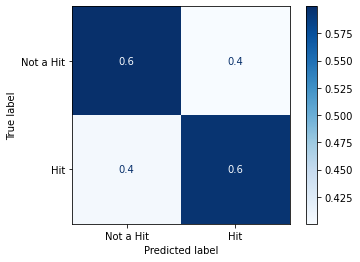

In [146]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(logreg, X_test_log, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


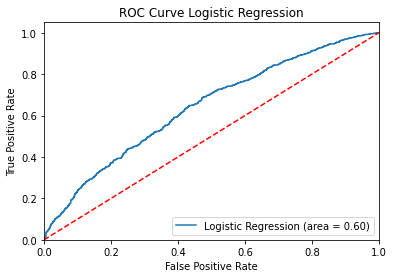

In [148]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_log))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_log)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Bagging Classifier

In [150]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [151]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5538949275362319

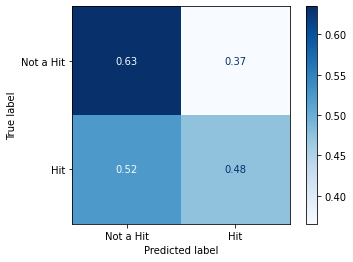

In [152]:
disp = plot_confusion_matrix(clf, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


## Fully Connected Neural Network

In [276]:
from tensorflow.keras import initializers
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(18,)),

    keras.layers.Dense(12, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    
#     keras.layers.Dense(6, activation=tf.nn.relu, kernel_initializer='normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [278]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [279]:

opt = keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_nn, y_train, epochs=100, batch_size=70, validation_split = 0.2)
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/100
59/59 [==============================] - 0s 4ms/step - loss: 0.7618 - accuracy: 0.5204 - val_loss: 0.7475 - val_accuracy: 0.5049
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 0.7553 - accuracy: 0.5214 - val_loss: 0.7420 - val_accuracy: 0.5117
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 0.7493 - accuracy: 0.5248 - val_loss: 0.7370 - val_accuracy: 0.5126
Epoch 4/100
59/59 [==============================] - 0s 2ms/step - loss: 0.7436 - accuracy: 0.5250 - val_loss: 0.7324 - val_accuracy: 0.5165
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 0.7383 - accuracy: 0.5262 - val_loss: 0.7279 - val_accuracy: 0.5223
Epoch 6/100
59/59 [==============================] - 0s 2ms/step - loss: 0.7333 - accuracy: 0.5267 - val_loss: 0.7238 - val_accuracy: 0.5184
Epoch 7/100
59/59 [==============================] - 0s 2ms/step - loss: 0.7286 - accuracy: 0.5328 - val_loss: 0.7199 - val_accuracy: 0.5194
Epoch 8/100
5

59/59 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.6092 - val_loss: 0.6685 - val_accuracy: 0.5932
Epoch 59/100
59/59 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6090 - val_loss: 0.6685 - val_accuracy: 0.5951
Epoch 60/100
59/59 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6097 - val_loss: 0.6683 - val_accuracy: 0.5922
Epoch 61/100
59/59 [==============================] - 0s 2ms/step - loss: 0.6560 - accuracy: 0.6092 - val_loss: 0.6683 - val_accuracy: 0.5903
Epoch 62/100
59/59 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.6092 - val_loss: 0.6683 - val_accuracy: 0.5913
Epoch 63/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6100 - val_loss: 0.6682 - val_accuracy: 0.5932
Epoch 64/100
59/59 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.6102 - val_loss: 0.6682 - val_accuracy: 0.5942
Epoch 65/100
59/59 

In [280]:
test_acc

0.5357789993286133

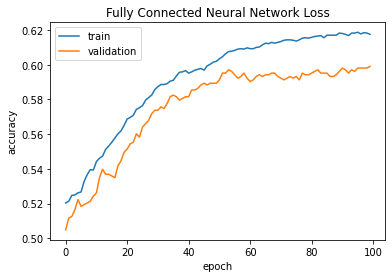

In [281]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [283]:
y_pred = model.predict(X_test_nn)

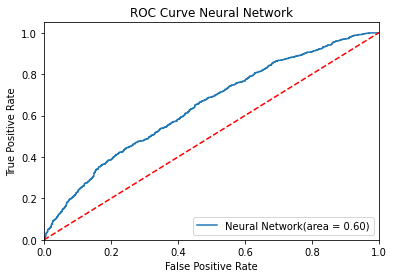

In [285]:
nn_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Neural Network(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Neural Network')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [282]:
model.save("data/NN1.h5")

## Gradient Boosting Classifier

In [359]:
# parameters = {
#     "learning_rate": [0.01],
#     "min_samples_split": [2,3,4,6,8],
#     "min_samples_leaf": [3,4,5,6],
#     "max_depth":[4,7,10,12],
#     "max_features":["log2"],
#     "criterion": ["friedman_mse"],
#     "subsample":[1.0],
#     "n_estimators":[700,900,1000]
#     }
# # pass param grid into GridSearchCV
# clf = GridSearchCV(GradientBoostingClassifier(), parameters,refit=False, n_jobs=-1)

# clf.fit(X_train, y_train)
# clf.best_params_

In [402]:
clfb = GradientBoostingClassifier(criterion= 'friedman_mse',
                                     learning_rate= 0.01,
                                     max_depth= 10, #4 #6
                                     max_features= 'log2',
                                     min_samples_leaf= 5,
                                     min_samples_split= 5, #0.1
                                     n_estimators= 900,
                                     subsample= 1)

In [403]:
clfb.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='log2', min_samples_leaf=5,
                           min_samples_split=5, n_estimators=900, subsample=1)

In [404]:
clfb.predict(X_test)
clfb.score(X_test, np.asarray(y_test).ravel())

0.6702898550724637

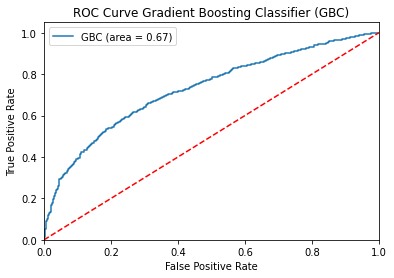

In [405]:
gbc_roc_auc = roc_auc_score(y_test, clfb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clfb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBC (area = %0.2f)' % gbc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Gradient Boosting Classifier (GBC)')
plt.legend(loc="upper left")
plt.show()

In [406]:
clfb.feature_importances_

array([0.06134339, 0.05385902, 0.05557644, 0.08303388, 0.06093974,
       0.0433348 , 0.06085993, 0.06585819, 0.06282836, 0.05836339,
       0.06956377, 0.02491619, 0.0855021 , 0.05678201, 0.05738265,
       0.02321233, 0.04044175, 0.03620204])

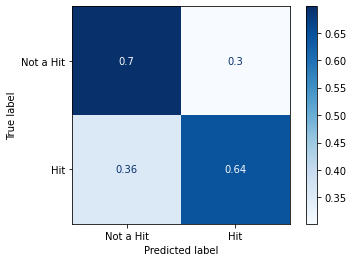

In [407]:
disp = plot_confusion_matrix(clfb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


## XGBoost

In [409]:
from xgboost import XGBClassifier

In [487]:
xgb = XGBClassifier(max_depth = 8, min_child_weight = 4, subsample = 0.8, colsample_bytree = 1
                        ,n_estimators = 500, booster = 'gbtree', objective= 'binary:logistic'
                      ,random_state = 42, learning_rate = 0.1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [488]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [489]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.04%


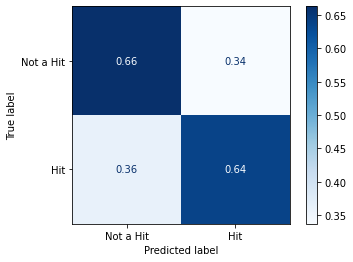

In [490]:
disp = plot_confusion_matrix(xgb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')
